<a href="https://colab.research.google.com/github/VickkiMars/CV_Mastery/blob/main/Traffic_signs_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: victorthamartian
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign


100%|██████████| 612M/612M [00:16<00:00, 38.3MB/s]


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [4]:
db_path = "/content/gtsrb-german-traffic-sign"
#train_path = db_path.join("")

In [5]:
os.listdir(db_path)

['meta',
 'Test.csv',
 'test',
 'Meta',
 'Test',
 'Train',
 'Meta.csv',
 'train',
 'Train.csv']

In [6]:
def read_csvs(file_path):
  db = pd.read_csv(file_path)
  print(len(db))
  print(db.head())
  return db

def print_(file_path):
  res = os.listdir(file_path)
  print(f"Number of items: {len(res)}")
  if len(res) < 44:
    print(f"Result:\n{res}")

In [7]:
for i in os.listdir(db_path):
  if i.endswith('.csv'):
    print(i)
    read_csvs(os.path.join(db_path, i))
    print()
  else:
    print(i)
    print_(os.path.join(db_path, i))
    print()

meta
Number of items: 45

Test.csv
12630
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

test
Number of items: 12631

Meta
Number of items: 45

Test
Number of items: 12631

Train
Number of items: 43
Result:
['42', '25', '2', '0', '27', '30', '9', '20', '35', '29', '23', '7', '34', '14', '3', '11', '17', '28', '22', '32', '8', '26', '31', '19', '33', '15', '39', '41', '24', '16', '12', '10', '1', '37', '18', '6', '4', '5', '36', '13', '38', '40', '21']

Meta.csv
43
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1    

From the above, it is clear that there are 43 classes,
images belonging to each class is in a separate folder
names after the index of the class, e.g class 1 -> Train/01/...png

Hence to load every image and its corresponding label,
we will get the label id's from the 'ClassId' column
and then use the 'Path' column in 'Train.csv' and 'Test.csv'
to load the images and their labels into a dataset.


In [8]:
train_csv = read_csvs(os.path.join(db_path,"Train.csv"))
test_csv = read_csvs(os.path.join(db_path,"Test.csv"))

39209
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
12630
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5   

In [9]:
# Get image size
for i in range(10):
  img_path = train_csv.loc[i, "Path"]
  img = mpimg.imread(os.path.join(db_path, img_path))
  print(img.shape)

(26, 27, 3)
(27, 28, 3)
(26, 29, 3)
(27, 28, 3)
(26, 28, 3)
(27, 31, 3)
(28, 31, 3)
(28, 31, 3)
(29, 31, 3)
(32, 34, 3)


We can see that the image shapes are varying, we will need to reshape them.
The size chosen for this project is 24x24, you can choose any dimensions that will suit you, but update your cnn accordingly.

In [10]:
import tensorflow as tf
import pathlib

In [11]:
db_path = pathlib.Path(db_path)
train_dir = db_path / "Train"
test_dir = db_path / "Test"

train_len, test_len = len(os.listdir(train_dir)), len(os.listdir(test_dir))
print(f"Number of training images: {train_len}")
print(f"Number of testing images: {test_len}")

IMG_HEIGHT = IMG_WIDTH = 32
BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE


Number of training images: 43
Number of testing images: 12631


In [12]:
image_paths = train_csv["Path"].values
image_paths = [str(train_dir).replace("/Train", "/"+img) for img in image_paths]
labels = train_csv["ClassId"].values

In [13]:
def preprocess_image(image):
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  #image /= 127.5  # normalize image values to be in the range [0,1]
  return image

def load_image(image_path):
  image = tf.io.read_file(image_path)
  return preprocess_image(image)

In [14]:
ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))
ds = ds.map(lambda img_path, label: (load_image(img_path), label), num_parallel_calls=AUTOTUNE)

In [15]:
train = ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Image Shape:  (32, 32, 3)
Label:  20
Image Shape:  (32, 32, 3)
Label:  1
Image Shape:  (32, 32, 3)
Label:  1
Image Shape:  (32, 32, 3)
Label:  1
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  1
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  20
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  20
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  0
Image Shape:  (32, 32, 3)
Label:  1
Image Shape:  (32, 32, 3)
Label:  20


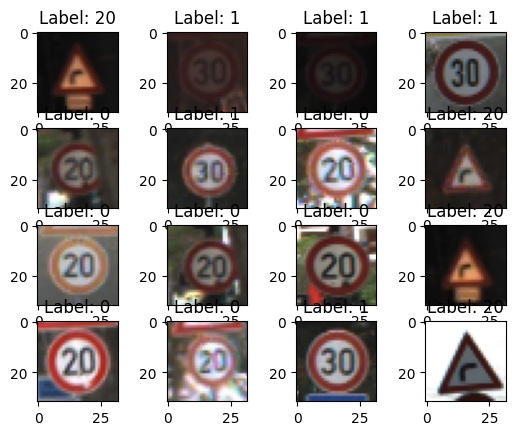

In [16]:
for image, label in train.take(1):
  for i in range(16):
    print("Image Shape: ", image[i].shape)
    print("Label: ", label[i].numpy())
    plt.subplot(4,4,i+1)
    plt.imshow(image[i])
    plt.title(f"Label: {label[i].numpy()}")


In [17]:
def create_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, (5,5), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Conv2D(64, (5,5), activation="relu"),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.MaxPooling2D(),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation="relu"),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Dense(43, activation="softmax"),
  ])
  return model


In [18]:
model = create_model()
model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])
history = model.fit(train, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2451/2451 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8225 - loss: 0.6250
Epoch 2/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9276 - loss: 0.2621
Epoch 3/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9668 - loss: 0.1141
Epoch 4/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9769 - loss: 0.0768
Epoch 5/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9822 - loss: 0.0653
Epoch 6/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9834 - loss: 0.0627
Epoch 7/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9843 - loss: 0.0551
Epoch 8/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9899 - loss: 0.0408
Epoch 9/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9879 - loss: 0.0444
Epoch 10/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9888 - loss: 0.0419
Epoch 11/50
2451/2451 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9908 - loss: 0.0455
Epoch 12/50


KeyboardInterrupt: 

In [19]:
test_paths = test_csv["Path"].values
test_paths = [str(test_dir).replace("/Test", "/"+img) for img in test_paths]
test_labels = test_csv["ClassId"].values

In [30]:
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
ds = test_ds.map(lambda img, label: (load_image(img), label), num_parallel_calls=AUTOTUNE)
test = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [31]:
model.evaluate(test)

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 32, 32, 3), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=False
  • mask=None

Image Shape:  ()
Label:  16


TypeError: Image data of dtype object cannot be converted to float

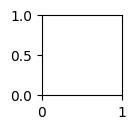

In [32]:
for image, label in test.take(1):
  for i in range(16):
    print("Image Shape: ", image[i].shape)
    print("Label: ", label[i].numpy())
    plt.subplot(4,4,i+1)
    plt.imshow(image[i])
    plt.title(f"Label: {label[i].numpy()}")
